In [1]:
from graphviz import Graph, Digraph

In [5]:
import pydot

In [353]:
def string_generator(title,design_dvs=None,operation_dvs=None,exog=None,energy_flow=None,mass_flow=None):
    design_dv_string = '' if design_dvs==None else '<br/>'.join([f'<font color="blue">{item}</font>' for item in design_dvs])+'<br/>'
    operation_dv_string = '' if operation_dvs==None else '<br/>'.join([f'<font color="blue">{item}</font>' for item in operation_dvs])+'<br/>'
    exog_string = '' if exog==None else '<br/>'.join([f'<font color="grey">{item}</font>' for item in exog])
    return f'<<font><b>{title}</b></font><br/>{design_dv_string}{operation_dv_string}{exog_string}>'

In [253]:
string_generator('wind',['capex','this','that'])

'<<font><b>wind</b></font><br/><font color="blue">capex</font><br/><font color="blue">this</font><br/><font color="blue">that</font><br/>>'

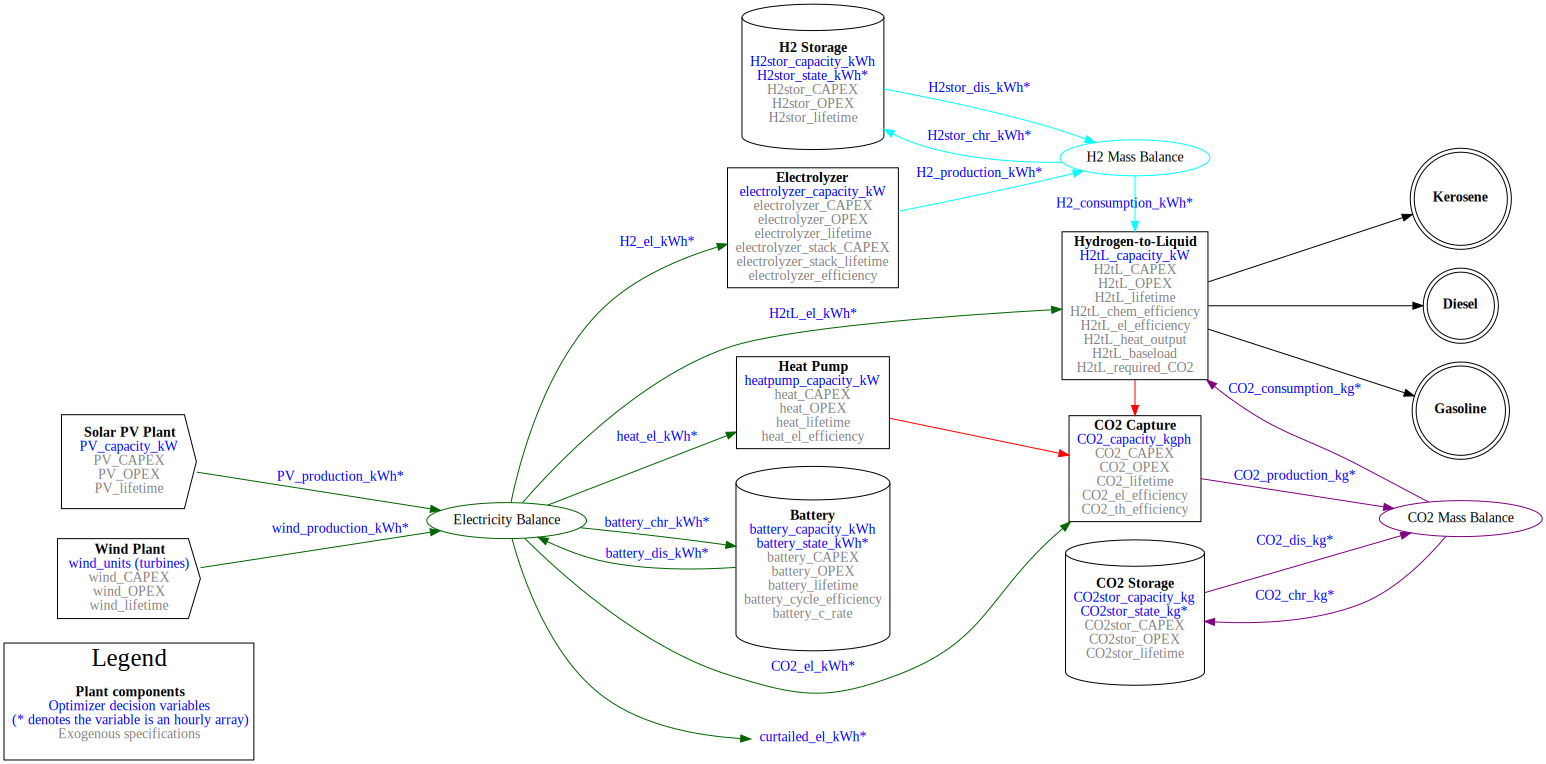

In [478]:
d = Digraph('plant',engine='dot',format='svg',filename='../../gfx/plant_flowchart')
d.graph_attr['rankdir'] = 'LR'

d.node('legend','''<
<font POINT-SIZE="25"><u>Legend</u><br/></font><br/>
<font><b>Plant components</b></font><br/>
<font color="blue">Optimizer decision variables<br/>
(* denotes the variable is an hourly array)</font><br/>
<font color="grey">Exogenous specifications</font>
<br/> >''',
       shape='rect',rankType='max')

d.attr('node',shape='oval')
d.node('electricity','Electricity Balance',color='darkgreen')
d.node('H2_mb','H2 Mass Balance',color='cyan')
d.node('CO2_mb','CO2 Mass Balance',color='purple')

d.attr('node',shape='rect')

d.node('pv',string_generator('Solar PV Plant',
                            design_dvs = ['PV_capacity_kW'],
                            operation_dvs  = None,
                            exog = ['PV_CAPEX','PV_OPEX','PV_lifetime']),
      shape='cds',margin='.25')
d.node('wind',string_generator('Wind Plant',
                            design_dvs = ['wind_units (turbines)'],
                            operation_dvs  = None,
                            exog = ['wind_CAPEX','wind_OPEX','wind_lifetime']),
      shape='cds',margin='.15')
d.node('electrolyzer',string_generator('Electrolyzer',
                            design_dvs = ['electrolyzer_capacity_kW'],
                            operation_dvs  = None,
                            exog = ['electrolyzer_CAPEX','electrolyzer_OPEX','electrolyzer_lifetime','electrolyzer_stack_CAPEX','electrolyzer_stack_lifetime','electrolyzer_efficiency']))
d.node('CO2',string_generator('CO2 Capture',
                            design_dvs = ['CO2_capacity_kgph'],
                            operation_dvs  = None,
                            exog = ['CO2_CAPEX','CO2_OPEX','CO2_lifetime','CO2_el_efficiency','CO2_th_efficiency']))
d.node('H2tL',string_generator('Hydrogen-to-Liquid',
                            design_dvs = ['H2tL_capacity_kW'],
                            operation_dvs  = None,
                            exog = ['H2tL_CAPEX','H2tL_OPEX','H2tL_lifetime','H2tL_chem_efficiency','H2tL_el_efficiency','H2tL_heat_output','H2tL_baseload','H2tL_required_CO2']))
d.node('battery',string_generator('<br/>Battery',
                            design_dvs = ['battery_capacity_kWh'],
                            operation_dvs  = ['battery_state_kWh*'],
                            exog = ['battery_CAPEX','battery_OPEX','battery_lifetime','battery_cycle_efficiency','battery_c_rate']),
      shape='cylinder')
d.node('H2stor',string_generator('<br/>H2 Storage',
                            design_dvs = ['H2stor_capacity_kWh'],
                            operation_dvs  = ['H2stor_state_kWh*'],
                            exog = ['H2stor_CAPEX','H2stor_OPEX','H2stor_lifetime']),
      shape='cylinder')
d.node('CO2stor',string_generator('<br/>CO2 Storage',
                            design_dvs = ['CO2stor_capacity_kg'],
                            operation_dvs  = ['CO2stor_state_kg*'],
                            exog = ['CO2stor_CAPEX','CO2stor_OPEX','CO2stor_lifetime']),
      shape='cylinder')
d.node('heat',string_generator('Heat Pump',
                            design_dvs = ['heatpump_capacity_kW'],
                            operation_dvs  = None,
                            exog = ['heat_CAPEX','heat_OPEX','heat_lifetime','heat_el_efficiency']))
d.attr('node',shape='none')
d.node('curtailed','curtailed_el_kWh*',fontcolor='blue')
d.attr('node',shape='doublecircle')
d.node('kerosene',string_generator('Kerosene'))
d.node('diesel',string_generator('Diesel'))
d.node('gasoline',string_generator('Gasoline'))

# Define electricity flows
d.attr('edge',color='darkgreen',fontcolor='blue')

d.edge('wind','electricity','wind_production_kWh*')
d.edge('electricity','battery','battery_chr_kWh*')
d.edge('battery','electricity','battery_dis_kWh*')
d.edge('pv','electricity','PV_production_kWh*')
d.edge('electricity','electrolyzer','H2_el_kWh*')
d.edge('electricity','CO2','CO2_el_kWh*')
d.edge('electricity','H2tL','H2tL_el_kWh*')
d.edge('electricity','heat','heat_el_kWh*')
d.edge('electricity','curtailed')


#Define H2 flows
d.attr('edge',color='cyan')
d.edge('electrolyzer','H2_mb','H2_production_kWh*')
d.edge('H2_mb','H2tL','H2_consumption_kWh*')
d.edge('H2stor','H2_mb','H2stor_dis_kWh*')
d.edge('H2_mb','H2stor','H2stor_chr_kWh*')

# Define CO2 flows
d.attr('edge',color='purple')
d.edge('CO2','CO2_mb','CO2_production_kg*')
d.edge('CO2_mb','H2tL','CO2_consumption_kg*')
d.edge('CO2stor','CO2_mb','CO2_dis_kg*')
d.edge('CO2_mb','CO2stor','CO2_chr_kg*')

# Define heat flows
d.attr('edge',color='red')
d.edge('heat','CO2')
d.edge('H2tL','CO2')

#Define fuel outputs
d.attr('edge',color='black')
d.edge('H2tL','kerosene')
d.edge('H2tL','diesel')
d.edge('H2tL','gasoline')
    
with d.subgraph() as a:
    a.attr(rank='same')
    a.node('heat')
    a.node('battery')
    a.node('electrolyzer')
#     a.node('H2_mb')
    a.node('H2stor')
with d.subgraph() as b:
    b.attr(rank='same')
    b.node('H2tL')
    b.node('CO2stor')
    b.node('CO2')
    b.node('H2_mb')
with d.subgraph() as c:
    c.node('wind')
    c.node('wind')
    c.node('legend')   
d

In [483]:
d.view()

'../../gfx/plant_flowchart.svg'